In [24]:
!pip install transformers
!pip install sentence_transformers
!pip install datasets
!pip install git+https://github.com/huggingface/accelerate.git

  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-88q7708b
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-88q7708b
  Resolved https://github.com/huggingface/accelerate.git to commit 02a8a9a3a778b18e9ec00ccfdb553504bf23ddb6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics as m

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import BertForSequenceClassification, BertTokenizer, AutoModel, TrainingArguments, Trainer
from transformers import RobertaForMaskedLM,RobertaTokenizer, pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from datasets import Dataset, ClassLabel, load_metric
from wordcloud import WordCloud
from torch.nn import Sigmoid
import torch
device = torch.device('cuda')
from sklearn.metrics import classification_report,  roc_auc_score, confusion_matrix


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1t/datasets/df_pp_stem_lemm.csv")
df = df.drop('Unnamed: 0',axis=1)
df.shape

(3184, 12)

In [28]:
# # 711 mb
model_rubertb = AutoModelForSequenceClassification.from_pretrained('s-nlp/rubert-base-cased-conversational-paraphrase-v1')
tokenizer_rubertb = AutoTokenizer.from_pretrained('s-nlp/rubert-base-cased-conversational-paraphrase-v1')



# ПОРОБОВАТЬ в КАЛАБЕ

# 1.42 Gb
# model_ruRobertaLv1 = RobertaForMaskedLM.from_pretrained('s-nlp/ruRoberta-large-paraphrase-v1', num_labels=df['sentiment'].nunique())
# tokenizer_ruRobertaLv1 = RobertaTokenizer.from_pretrained('s-nlp/ruRoberta-large-paraphrase-v1')

# 1.42 Gb
# model_ruRobertaL = RobertaForMaskedLM.from_pretrained('sberbank-ai/ruRoberta-large', num_labels=df['sentiment'].nunique())
# tokenizer_ruRobertaL = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

# !!!!!!!!!!!!! Модели очень  большие  для моего ноута !!!!!!!!!


# unmasker = pipeline('fill-mask', model=model,tokenizer=tokenizer)
# unmasker("Стоит чаще писать на Хабр про <mask>.")


In [29]:
model = model_rubertb
tokenizer = tokenizer_rubertb

<Axes: >

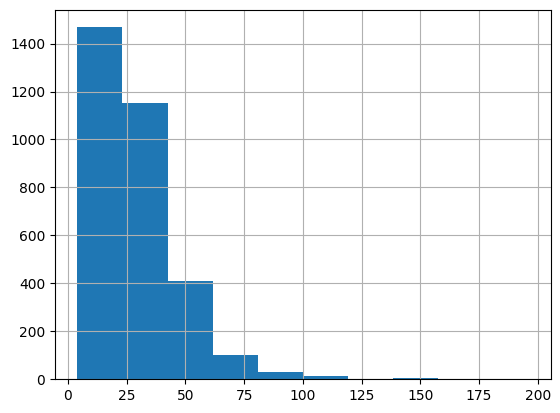

In [30]:
df['name'].apply(lambda x: len(tokenizer.encode(x))).hist()

In [31]:
data = Dataset.from_pandas(df)
data = data.class_encode_column("sentiment")
data = data.train_test_split(test_size=0.2, stratify_by_column='sentiment', seed=42)

Stringifying the column:   0%|          | 0/3184 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3184 [00:00<?, ? examples/s]

In [32]:
def tokenize_function(row):
    return tokenizer(row['name'],
              truncation=True,
              max_length=100,
              padding='max_length')

train = data['train'].map(tokenize_function, batched=True)
test = data['test'].map(tokenize_function, batched=True)

train = train.rename_column("sentiment", "label")
test = test.rename_column("sentiment", "label")

Map:   0%|          | 0/2547 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

In [33]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [34]:
# def calculate_class_weights(df, target_column):
#     classes = np.unique(df[target_column])
#     class_weights = compute_class_weight('balanced', classes=classes, y=df[target_column])
#     weights_tensor = torch.tensor(class_weights, dtype=torch.float)
#     return weights_tensor

In [35]:
# def compute_loss_with_class_weights(pred, class_weights):
#     logits = pred.predictions
#     targets = pred.label_ids

#     # Применяем веса классов к потерям с использованием взвешенной кросс-энтропии
#     loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
#     loss = loss_fct(logits.view(-1, logits.shape[-1]), targets.view(-1))

#     return loss

In [36]:
training_args = TrainingArguments(output_dir="temp",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  save_steps=200,
                                  per_device_eval_batch_size=64,
                                  per_device_train_batch_size=64,
                                  report_to='none')


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset={"TRAIN": train, "VALID": test},
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Valid Loss,Valid Accuracy
1,No log,No log,0.084369,0.968198,0.129185,0.954474
2,No log,No log,0.044008,0.986258,0.143113,0.948195
3,No log,No log,0.022007,0.992933,0.163934,0.956044
4,No log,No log,0.006761,0.997252,0.193194,0.957614
5,No log,No log,0.002292,0.999215,0.209626,0.948195


TrainOutput(global_step=200, training_loss=0.0853774356842041, metrics={'train_runtime': 306.1646, 'train_samples_per_second': 41.595, 'train_steps_per_second': 0.653, 'total_flos': 654437361330000.0, 'train_loss': 0.0853774356842041, 'epoch': 5.0})

In [38]:
# сохраняем веса
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/1t/nlp_models/saved_weights_tokenizer_rubert-base-cased-conversational-paraphrase-v1.pt')
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/1t/nlp_models/saved_weights_model_rubert-base-cased-conversational-paraphrase-v1.pt')

In [39]:
preds = trainer.predict(test)

In [40]:
threshold = 0.5

test_probas = torch.sigmoid(torch.from_numpy(preds.predictions[:, 1]))

test_labels = test_probas.numpy() > threshold
test_labels = test_labels.tolist()

print(m.classification_report(test['label'], test_labels))

roc_auc = roc_auc_score(test['label'], test_probas)
print(f"ROC-AUC: {roc_auc}")

conf_matrix = confusion_matrix(test['label'], test_labels)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       589
           1       0.66      0.65      0.65        48

    accuracy                           0.95       637
   macro avg       0.82      0.81      0.81       637
weighted avg       0.95      0.95      0.95       637

ROC-AUC: 0.9666454442558008
Confusion Matrix:
[[573  16]
 [ 17  31]]


In [ ]:
# sns.histplot(test_probas, hue=test['label'])

-----

Пробуем прокинуть веса классов

In [55]:
class_weights = compute_class_weight('balanced', classes=np.unique(train['label']), y=train['label'])
print(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float)

[0.5405348  6.66753927]


In [56]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 2 labels with different weights)
        # loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([6.66753927, 0.5405348], device=model.device))
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [57]:
training_args = TrainingArguments(output_dir="temp",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  save_steps=200,
                                  per_device_eval_batch_size=64,
                                  per_device_train_batch_size=64,
                                  report_to='none')


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset={"TRAIN": train, "VALID": test},
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [58]:
trainer.train()

<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))


Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Valid Loss,Valid Accuracy
1,No log,No log,0.089475,0.995289,1.536282,0.937206
2,No log,No log,0.099981,0.995681,1.942714,0.940345
3,No log,No log,0.002254,0.999607,1.293240,0.945055
4,No log,No log,0.011405,0.999607,1.621637,0.948195
5,No log,No log,0.004073,0.999607,1.632276,0.949765


<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To 

TrainOutput(global_step=200, training_loss=0.05518048286437988, metrics={'train_runtime': 297.6065, 'train_samples_per_second': 42.791, 'train_steps_per_second': 0.672, 'total_flos': 654437361330000.0, 'train_loss': 0.05518048286437988, 'epoch': 5.0})

In [59]:
preds = trainer.predict(test)

<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))


In [62]:
threshold = 0.25

test_probas = torch.sigmoid(torch.from_numpy(preds.predictions[:, 1]))

test_labels = test_probas.numpy() > threshold
test_labels = test_labels.tolist()

print(m.classification_report(test['label'], test_labels))

roc_auc = roc_auc_score(test['label'], test_probas)
print(f"ROC-AUC: {roc_auc}")

conf_matrix = confusion_matrix(test['label'], test_labels)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       589
           1       0.63      0.65      0.64        48

    accuracy                           0.95       637
   macro avg       0.80      0.81      0.80       637
weighted avg       0.95      0.95      0.95       637

ROC-AUC: 0.9598189020939445
Confusion Matrix:
[[571  18]
 [ 17  31]]


---- СТАЛО ХУЖЕ !!